# Set up Spark



In [6]:
import findspark
findspark.init()
findspark.find()

'/home/drbenciv/.local/lib/python3.8/site-packages/pyspark'

In [7]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local[4]")\
        .appName("CoCalc")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

your 131072x1 screen size is bogus. expect trouble


22/12/15 22:00:41 WARN Utils: Your hostname, Dante-Gram resolves to a loopback address: 127.0.1.1; using 172.28.114.193 instead (on interface eth0)
22/12/15 22:00:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/15 22:00:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/12/15 22:00:43 WARN Utils: Service 'SparkUI' could not bind on port 4050. Attempting port 4051.


In [8]:
sc = spark.sparkContext

In [9]:
test = sc.parallelize([1, 2, 3, 4, 5])

def times_two(x):
  return x * 2

rdd = test.map(times_two)
rdd.collect()

[2, 4, 6, 8, 10]

# Test Data Integrity



In [10]:
from datetime import datetime

with open('EPM_Dataset_2/Data/Processes/Session 6/99.txt') as file:
  invalid = 0
  total = 0
  for line in file:
    total += 1

    line = line.split(', ')
    start_time = line[4]
    end_time = line[5]
    idle_time = int(line[6])

    # parse start and end time into datetime objects
    start_datetime = datetime.strptime(start_time, '%d.%m.%Y %H:%M:%S')
    # print(start_datetime)

    end_datetime = datetime.strptime(end_time, '%d.%m.%Y %H:%M:%S')
    # print(end_datetime)

    diff = end_datetime - start_datetime

    if (diff.total_seconds() * 1000 < idle_time): # idle_time is in millis
      invalid += 1

  invalid_percent = invalid / total * 100
  print(f'Invalid: {round(invalid_percent, 2)}%')


Invalid: 23.63%


# Transform Data

In [11]:
from datetime import datetime


NUM_SESSIONS = 6

with open('EPM_Dataset_2/features.txt') as feature_file:
    OG_FEATURES = [line.split()[1] for line in feature_file]


USED_FEATURES = ["session", "student_Id", "start_time", "end_time", "activity", "keystroke"]
NEW_FEATURES = ["total time in session", "time spent in other", "total keystrokes in session"]

"""
Read all observations from the give sessions(s) and student(s) and key-value pairs where
Key = (session number, student number)
Value = (total time spent in lab, total time spent in non-work activity, total number of work-related keystrokes)
"""
def get_observations(session_numbers, student_numbers, debug=False):
    if hasattr(session_numbers, '__iter__'): # also support a single session
        session_numbers = list(session_numbers)
    else:
        session_numbers = [session_numbers]
    if hasattr(student_numbers, '__iter__'): # or a single student
        student_numbers = list(student_numbers)
    else:
        student_numbers = [student_numbers]
    paths = [] # make a list of paths for existing students

    for session_number in session_numbers:
        for student_number in student_numbers:
            path = f'EPM_Dataset_2/Data/Processes/Session {session_number}/{student_number}.txt'

            if os.path.isfile(path):
                paths.append(path)
            else:
                path = f'EPM_Dataset_2/Data/Processes/Session {session_number}/{student_number} 2.txt'
                if os.path.isfile(path):
                    paths.append(path)
                elif debug: print(f'Session {session_number} student {student_number} not found')

    if not paths: return sc.emptyRDD() # in case there's no valid entries
    rddRaw = sc.textFile(','.join(paths)) # read all the existing entries together into one RDD
    """
    Remove all but 3 observations in the line
    Input is a string, output is a list
     """
    def delete_unused(obs):
        obs = obs.split(",")
        output = []

        for key, value in zip(OG_FEATURES, obs):
            if key in USED_FEATURES:
                output.append(value.strip())

        return output

    rddTrimmed = rddRaw.map(delete_unused)


    """
    Convert the start and end times into datetime objects, and make the key the session, student, and a Boolean flag representing whether they were working producitvely or not
    """
    def datetimeify(obs):
        session, student_id, activity, start, end, keystrokes = obs
        strp = lambda s : datetime.strptime(s, '%d.%m.%Y %H:%M:%S')
        start = int(strp(start).timestamp())
        end = int(strp(end).timestamp())
        total = end - start
        return (
                    (int(session), int(student_id), activity != "Other" and activity != "Blank"), # key
                    (start, end, total, int(keystrokes)) # value
                )

    rddFormatted = rddTrimmed.map(datetimeify)

    """
    Associative and commutative function to get the earliest start time, latest end time, total time in the activity, and total keystrokes
    """
    def aggregateData(value1, value2):
        return (min(value1[0], value2[0]), max(value1[1], value2[1]), value1[2] + value2[2], value1[3] + value2[3])

    rddAggregated = rddFormatted.reduceByKey(aggregateData)

    """
    Reduce the key to just the student in order to aggregate their data
    Set up three features per session, the total time spent working in the lab, total time spent on other, and total number of keystrokes
    """
    def extractFinalFeatures(obs):
        key, value = obs
        session, student, working = key
        session_start = (session - session_numbers[0])*3 # index where this session data begins (assuming sessions are sequential)
        start, end, time, keystrokes = value
        features = [0]*(len(session_numbers)*3)
        if working:
            features[session_start] = end - start # time spent working in lab
            features[session_start + 2] = keystrokes # keystrokes spent working
        else:
            features[session_start + 1] = time # time spent in other activities
        return (student, features) # make session and activity a value

    rddFlattened = rddAggregated.map(extractFinalFeatures).reduceByKey(lambda a, b: map(int.__add__, a, b)).mapValues(lambda mapObject: list(mapObject))

    return rddFlattened

from time import perf_counter
start = perf_counter()
observations = get_observations(range(1,7), range(1,116))
observations.cache()
mid = perf_counter()
for observation in observations.take(5):
    print(f"Student {observation[0]}: {observation[1]}")
end = perf_counter()
print(f"Step 1: {mid - start} Step 2: {end - mid}")


Student 1: [7191, 485, 1108, 9101, 188, 3242, 0, 0, 0, 5724, 176, 2763, 7257, 53, 3757, 11440, 167, 1696]
Student 2: [4577, 247, 1047, 9063, 223, 5151, 10047, 90, 4873, 4611, 183, 2232, 5559, 135, 3142, 6392, 323, 1140]
Student 3: [0, 0, 0, 8887, 293, 4330, 9820, 155, 4863, 5859, 89, 1945, 6093, 202, 4693, 0, 0, 0]
Student 4: [5441, 689, 1363, 9190, 735, 5341, 10709, 306, 6391, 3365, 277, 3384, 5990, 550, 3537, 11329, 630, 1881]
Student 5: [5569, 909, 1207, 8552, 183, 5450, 8995, 178, 7433, 3662, 185, 2369, 5457, 102, 2701, 10169, 355, 1552]
Step 1: 0.6919522239986691 Step 2: 17.44096922800236


In [12]:
"""
Merge the two final grades, and if students took it twice just record their first grade
"""
with open("EPM_Dataset_2/Data/final_grades_first.csv", 'r') as first, open("EPM_Dataset_2/Data/final_grades_second.csv", 'r') as second, open("EPM_Dataset_2/Data/final_grades_merged.csv", 'w') as merged:
  first.readline(); first.readline() # header lines
  second.readline(); second.readline()
  line1 = first.readline().split(',')
  rows = len(line1) # needed to extract student id and final grade (last data point)
  id1 = int(line1[0]) # extract ID number from line
  line2 = second.readline().split(',')
  id2 = int(line2[0])
  while id1 < 1000 or id2 < 1000: # 1000 = finished reading
    if id2 <= id1:
      if id2 < id1: merged.write(','.join(line2[::rows-1])) # if a student wrote both exams, don't record the second one
      line2 = second.readline().split(',') # move on to next student
      id2 = int(line2[0]) if line2[0] else 1000
    else:
      merged.write(','.join(line1[::rows-1]))
      line1 = first.readline().split(',')
      id1 = int(line1[0]) if line1[0] else 1000

In [13]:
import csv
grades = []
path = 'EPM_Dataset_2/Data/final_grades_merged.csv'
def getKVpairs(s):
    student, grade = s.split(',')
    return int(student), float(grade)
gradesRDD = sc.textFile(path).map(getKVpairs)
gradesRDD.take(3)

[(1, 94.5), (2, 44.0), (3, 85.0)]

In [14]:
observations.cache()
labelled_obs = gradesRDD.join(observations).map(lambda obs: f"{obs[1][0]},{','.join([str(i) for i in obs[1][1]])}")
labelled_obs.cache()
print(labelled_obs.take(5))

['94.5,7191,485,1108,9101,188,3242,0,0,0,5724,176,2763,7257,53,3757,11440,167,1696', '44.0,4577,247,1047,9063,223,5151,10047,90,4873,4611,183,2232,5559,135,3142,6392,323,1140', '85.0,0,0,0,8887,293,4330,9820,155,4863,5859,89,1945,6093,202,4693,0,0,0', '30.0,5441,689,1363,9190,735,5341,10709,306,6391,3365,277,3384,5990,550,3537,11329,630,1881', '38.5,5569,909,1207,8552,183,5450,8995,178,7433,3662,185,2369,5457,102,2701,10169,355,1552']


# Creating Models



In [15]:
print(labelled_obs.take(1))

['94.5,7191,485,1108,9101,188,3242,0,0,0,5724,176,2763,7257,53,3757,11440,167,1696']


In [16]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

In [17]:
def parseData(line):
    label_features = line.split(",")
    ret_val = LabeledPoint(label_features[0],label_features[1:])
    return ret_val

parsedSamplePoints = labelled_obs.map(parseData)
parsedSamplePoints.cache()
firstPoint = parsedSamplePoints.take(1)
firstPointFeatures = firstPoint[0].features
firstPointLabel = firstPoint[0].label
print(firstPoint)
print(firstPointFeatures, firstPointLabel)
print(len(firstPointFeatures))

[LabeledPoint(94.5, [7191.0,485.0,1108.0,9101.0,188.0,3242.0,0.0,0.0,0.0,5724.0,176.0,2763.0,7257.0,53.0,3757.0,11440.0,167.0,1696.0])]
[7191.0,485.0,1108.0,9101.0,188.0,3242.0,0.0,0.0,0.0,5724.0,176.0,2763.0,7257.0,53.0,3757.0,11440.0,167.0,1696.0] 94.5
18


In [18]:
def prepareNormalization(nonNormalizedRDD, debug=False):
    if debug: print("starting")
    nonNormalizedRDD.cache()
    numObservations = nonNormalizedRDD.count()
    if debug: print(nonNormalizedRDD.take(2))
    numFeatures = len(nonNormalizedRDD.take(1)[0].features)
    if debug: print(f"{numObservations=} {numFeatures=}")
    combOp = (lambda a, b: map(float.__add__, a, b))
    seqOp = (lambda a, b: combOp(a, b.features))
    if debug: print("Starting aggregation")
    meanList = list(map(lambda x: x / numObservations, nonNormalizedRDD.aggregate(tuple([0.0]*numFeatures), seqOp, combOp)))
    if debug: print(f"{meanList=}")
    global broadcastMean
    broadcastMean = sc.broadcast(meanList)
    seqOp = (lambda a, b: combOp(a, [(feature-broadcastMean.value[index])**2 for index, feature in enumerate(b.features)]))
    stdevList = list(map(lambda x: (x / numObservations)**0.5, nonNormalizedRDD.aggregate(tuple([0.0]*numFeatures), seqOp, combOp)))
    if debug: print(f"{stdevList=}")
    global broadcastStdev
    broadcastStdev = sc.broadcast(stdevList)

    global meanGrade
    meanGrade = sc.broadcast(nonNormalizedRDD.map(lambda lp: lp.label).mean())
    global stdevGrade
    stdevGrade = sc.broadcast(nonNormalizedRDD.map(lambda lp: lp.label).stdev())

def normalizeFeatures(lp):
    normalizedFeatures = list()
    for i in range (0,len(lp.features)):
        feature = (lp.features[i]-broadcastMean.value[i])/broadcastStdev.value[i]
        normalizedFeatures.insert(i,feature)
    return LabeledPoint((lp.label - meanGrade.value)/stdevGrade.value, normalizedFeatures)

In [19]:
# Training, test, and validation setup

weights = [0.6, 0.2, 0.2] # train/test/cv
seed = 53
unnormalizedTrainData, unnormalizedTestData, unnormalizedCVData = parsedSamplePoints.randomSplit(weights,seed)

# normalize based on training data *only* to avoid information leakage
prepareNormalization(unnormalizedTrainData)

parsedTrainData = unnormalizedTrainData.map(normalizeFeatures).cache()
print(parsedTrainData.take(1))
parsedTestData = unnormalizedTestData.map(normalizeFeatures).cache()
parsedCVData = unnormalizedCVData.map(normalizeFeatures).cache()

nTrain = parsedTrainData.count()
nTest = parsedTestData.count()
nCV = parsedCVData.count()

print (nTrain, nTest, nCV, nTrain+nTest+nCV)
print (parsedSamplePoints.count())

[LabeledPoint(-0.13091802593781937, [0.2828343870376832,-0.25250172480939054,0.40884265440039474,0.5167458551692643,-0.3333959693469496,0.8597497396212153,0.5036005339926257,-0.4988167049543678,0.5720600637587105,0.0005206262084083754,-0.2694382938600449,0.269375349927984,0.05723279996709633,-0.43279194511518276,0.3302292579240702,-0.6396690058530655,-0.023547892105960252,-0.13554121693463725])]


56 16 21 93


93


In [20]:
# Creating baseline model for just guessing the average (equals zero after normalization)
# Hopefully our model is better than just guessing the average grade

averageGrade = 0
print(averageGrade*stdevGrade.value + meanGrade.value)

47.53571428571429


In [21]:
# Root mean square error
# Needs data to come in the form label, prediction

import math

def squaredError(label, prediction):
    error = (label-prediction)*(label-prediction)
    return error

"""Calculates the root mean squared error for an `RDD` of (label, prediction) tuples.

Args:
    LabelsAndPredictions (RDD of (float, float)): An `RDD` consisting of (label, prediction) tuples.

Returns:
    float: The square root of the mean of the squared errors.
"""
def RootMeanSquareError(LabelsAndPredictions):
    sqrSum = LabelsAndPredictions.map(lambda s: (squaredError(s[0],s[1]),1.0)).reduce(lambda a, b: (a[0]+b[0], a[1]+b[1]))
    return math.sqrt(sqrSum[0]/sqrSum[1])



In [22]:
# Using our training and validation data against an average guess for grade

LabelandPredTrain = parsedTrainData.map(lambda x: (x.label, averageGrade))
rmseTrainBase = RootMeanSquareError(LabelandPredTrain)

LabelandPredCV = parsedCVData.map(lambda x: (x.label, averageGrade))
rmseCVBase = RootMeanSquareError(LabelandPredCV)


print('Baseline Train RMSE = {0:.3f}'.format(rmseTrainBase))
print('Baseline Validation RMSE = {0:.3f}'.format(rmseCVBase))

Baseline Train RMSE = 1.000
Baseline Validation RMSE = 0.953


In [23]:
# Linear Regression

from pyspark.mllib.linalg import DenseVector
from pyspark.mllib.regression import LinearRegressionWithSGD
# Values to use when training the linear regression model
numIters = 500  # iterations
alpha = 1.0  # step changed from 1.0 to 0.5 to 0.1
miniBatchFrac = 1.0  # miniBatchFraction
reg = 1.3  # regParam, optimized based on minimizing CV RMSE
regType = 'l2'  # regType
useIntercept = False  # no intercept because we are normalizing based on training data

In [24]:
# This test shows that regularization affects the intercept (which should be
# one), contrary to standard practice
testing = sc.parallelize([LabeledPoint(1,[-1]), LabeledPoint(1,[1])])
testModel = LinearRegressionWithSGD.train(testing,numIters,alpha,miniBatchFrac,initialWeights=None,regParam=1,regType=regType,intercept=True)
print(testModel.weights, testModel.intercept)

/home/drbenciv/.local/lib/python3.8/site-packages/pyspark/mllib/regression.py:367: FutureWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.", FutureWarning)


[0.0] 0.5


In [25]:
model1 = LinearRegressionWithSGD.train(parsedTrainData,numIters,alpha,miniBatchFrac,initialWeights=None,regParam=reg,regType=regType,intercept=useIntercept)

weightsLR1 = model1.weights
interceptLR1 = model1.intercept # equals zero since training data's average is zero
print(weightsLR1, interceptLR1)

[-0.06966625667204569,0.0015639378974160309,-0.00893714406205204,0.005482801999114707,0.05862073299035709,0.037637792938630996,0.04795244146264191,-0.017786358772817302,0.03535746920606743,-0.03858402135063102,-0.0981623591101505,0.015975170506702236,-0.04890082892493478,0.011064940367745676,0.10836028953999428,0.06638433818513119,-0.02323916654593319,0.08454388015481669] 0.0


In [26]:
# Prediction

samplePoint = parsedTrainData.take(1)[0]
samplePrediction = model1.predict(samplePoint.features)
sampleGrade = samplePoint.label
print(samplePrediction*stdevGrade.value + meanGrade.value, sampleGrade)

48.9048481124298 -0.13091802593781937


In [27]:
# Calculating RMSE
LabelandPredictionsTrain = parsedTrainData.map(lambda lp: (lp.label, model1.predict(lp.features)))
rmseTrainLR1 = RootMeanSquareError(LabelandPredictionsTrain)
print(f"{rmseTrainBase=}")
print(f"{rmseTrainLR1=}")

LabelandPredictionsCV = parsedCVData.map(lambda lp: (lp.label, model1.predict(lp.features)))
rmseCVLR1 = RootMeanSquareError(LabelandPredictionsCV)
print(f"{rmseCVBase=}")
print(f"{rmseCVLR1=}")


rmseTrainBase=0.9999999999999999
rmseTrainLR1=0.8866452977020763


rmseCVBase=0.9527220168378452
rmseCVLR1=0.8970156946610404


In [28]:
# Attempting Second Order Model

def transformOrderTwo(lp):
    """Transforms the features in the LabeledPoint object lp into higher order features.

    Args:
        lp - LabeledPoint object 

    Returns:
        LabeledPoint: The object contains the label and the higher order features
    """
    Sq1 = lp.features[0]*lp.features[0]
    Sq2 = lp.features[1]*lp.features[1]
    Sq3 = lp.features[2]*lp.features[2]
    Sq4 = lp.features[3]*lp.features[3]
    Sq5 = lp.features[4]*lp.features[4]
    Sq6 = lp.features[5]*lp.features[5]
    Sq7 = lp.features[6]*lp.features[6]
    Sq8 = lp.features[7]*lp.features[7]
    Sq9 = lp.features[8]*lp.features[8]
    Sq10 = lp.features[9]*lp.features[9]
    Sq11 = lp.features[10]*lp.features[10]
    Sq12 = lp.features[11]*lp.features[11]
    Sq13 = lp.features[12]*lp.features[12]
    Sq14 = lp.features[13]*lp.features[13]
    Sq15 = lp.features[14]*lp.features[14]
    Sq16 = lp.features[15]*lp.features[15]
    Sq17 = lp.features[16]*lp.features[16]
    Sq18 = lp.features[17]*lp.features[17]
    return LabeledPoint(lp.label,[lp.features[0],lp.features[1],lp.features[2],lp.features[3],lp.features[4],lp.features[5],lp.features[6],lp.features[7],lp.features[8],lp.features[9],lp.features[10],lp.features[11],lp.features[12],lp.features[13],lp.features[14],lp.features[15],lp.features[16],lp.features[17],Sq1,Sq2,Sq3,Sq4,Sq5,Sq6,Sq7,Sq8,Sq9,Sq10,Sq11,Sq12,Sq13,Sq14,Sq15,Sq16,Sq17,Sq18])

unnormalizedTrainDataOrderTwo = parsedTrainData.map(transformOrderTwo)
prepareNormalization(unnormalizedTrainDataOrderTwo) # normalizes new features (old features are already normalized)
parsedTrainDataOrderTwo = unnormalizedTrainDataOrderTwo.map(normalizeFeatures)
print(parsedTrainDataOrderTwo.take(2))
parsedTestDataOrderTwo = parsedTestData.map(transformOrderTwo).map(normalizeFeatures)
parsedCVDataOrderTwo = parsedCVData.map(transformOrderTwo).map(normalizeFeatures)

[LabeledPoint(-0.13091802593781912, [0.28283438703768304,-0.25250172480939054,0.4088426544003948,0.5167458551692644,-0.3333959693469496,0.859749739621215,0.5036005339926258,-0.498816704954368,0.5720600637587104,0.0005206262084084389,-0.26943829386004486,0.26937534992798406,0.057232799967096466,-0.4327919451151827,0.33022925792407015,-0.6396690058530653,-0.02354789210596022,-0.13554121693463728,-0.5079094391136851,-0.3500544717889186,-0.45995732544477397,-0.5410906642368777,-0.28065240693110344,-0.23425155238397607,-0.40318110204930746,-0.16734948082191684,-0.5375303868215372,-0.4933354769930075,-0.2566016371259124,-0.46959652613855096,-0.5237545288444206,-0.2500150530794837,-0.48388209299597384,-0.2969073026911929,-0.2670847343464464,-0.1400397254372772]), LabeledPoint(-0.33456828850775994, [0.5965789879426007,1.226989968273228,0.6350377876777975,0.3851613867544174,-0.4265372728312558,1.000048643596749,0.20532060699819993,-0.31201157371224275,1.835724076154105,-0.5215201137851482,-0.26

In [29]:
nTrain = parsedTrainDataOrderTwo.cache().count()
nCV = parsedCVDataOrderTwo.cache().count()
nTest = parsedTestDataOrderTwo.cache().count()

print(nTrain, nCV, nTest, nTrain + nTest + nCV)

56 21 16 93


In [30]:
reg = 20 # optimizing based on minimizing CV RMSE
secondModel = LinearRegressionWithSGD.train(parsedTrainDataOrderTwo,numIters,min(alpha,alpha/reg),miniBatchFrac,initialWeights=None,regParam=reg,regType=regType,intercept=False)

weightsLR2 = secondModel.weights
print(weightsLR2)

[-0.005258715753212346,-0.0004903078214971582,-0.00031878856268153296,0.005968745030139435,0.00771077865973009,0.008897907366251933,0.006984945876229189,-0.0029155316426621837,0.00752797686247649,-0.006248165364293503,-0.012865334629237848,0.0034752678664647504,-0.0009424438860876679,0.0023283803998504337,0.012731949808163813,0.008237683120346657,-0.0028074442888936374,0.011069600485015759,-0.007864026102891011,0.004237928655625283,0.0010595384906743532,-0.0037211303664560257,0.006815770433080971,2.2054294352155588e-05,-0.009458038352191838,-0.0058773596171234534,-0.010725693930596258,0.0010128659469974103,-0.007208689753365706,-0.00350951261649984,-0.006055931146651765,0.002483621444327919,0.007500343403884185,-0.005329640986541179,-0.004751424740691597,0.00833682433682399]


In [31]:
labelsAndPredsOrderTwo = parsedCVDataOrderTwo.map(lambda lp: (lp.label,secondModel.predict(lp.features)))
rmseCVLR2 = RootMeanSquareError(labelsAndPredsOrderTwo)

print(rmseCVBase)
print(rmseCVLR1)
print(rmseCVLR2)

0.9527220168378452
0.8970156946610404
0.9467089218366738


In [32]:
# Random Forest

from pyspark.mllib.tree import RandomForest
from pyspark.ml.evaluation import RegressionEvaluator
# parsedTrainData
dtModel = RandomForest.trainRegressor(parsedTrainData, categoricalFeaturesInfo={},
                                      numTrees=8, featureSubsetStrategy="auto",
                                      impurity='variance', maxDepth=5, maxBins=32)
predictions = dtModel.predict(parsedCVData.map(lambda x: x.features)).collect()
labels = parsedCVData.map(lambda x: x.label).collect()
rmseCVDT = np.sqrt(np.mean((np.array(predictions)-np.array(labels))**2))


print(rmseCVBase)
print(rmseCVLR1)
print(rmseCVLR2)
print(rmseCVDT)

0.9527220168378452
0.8970156946610404
0.9467089218366738
0.8099728807415508


## Check performance of test data (withheld until this point from training) and visualize predictions

In [40]:
labelsAndPredsTestBase = parsedTestData.map(lambda x: (x.label, averageGrade))
rmseTestBase = RootMeanSquareError(labelsAndPredsTestBase)
print(f"{rmseTestBase=}")

labelsAndPredsTestR1 = parsedTestData.map(lambda lp: (lp.label,model1.predict(lp.features)))
rmseTestLR1 = RootMeanSquareError(labelsAndPredsTestR1)
print(f"{rmseTestLR1=}")

labelsAndPredsTestR2 = parsedTestDataOrderTwo.map(lambda lp: (lp.label,secondModel.predict(lp.features)))
rmseTestLR2 = RootMeanSquareError(labelsAndPredsTestR2)
print(f"{rmseTestLR2=}")

DTTestpredictions = dtModel.predict(parsedTestData.map(lambda x: x.features)).collect()
DTTestlabels = parsedTestData.map(lambda x: x.label).collect()
rmseTestDT = np.sqrt(np.mean((np.array(DTTestpredictions)-np.array(DTTestlabels))**2))
print(f"{rmseTestDT=}")

rmseTestBase=1.2161457932538393


rmseTestLR1=1.2770069591621636


rmseTestLR2=1.2163645703223056


rmseTestDT=1.222373616997945


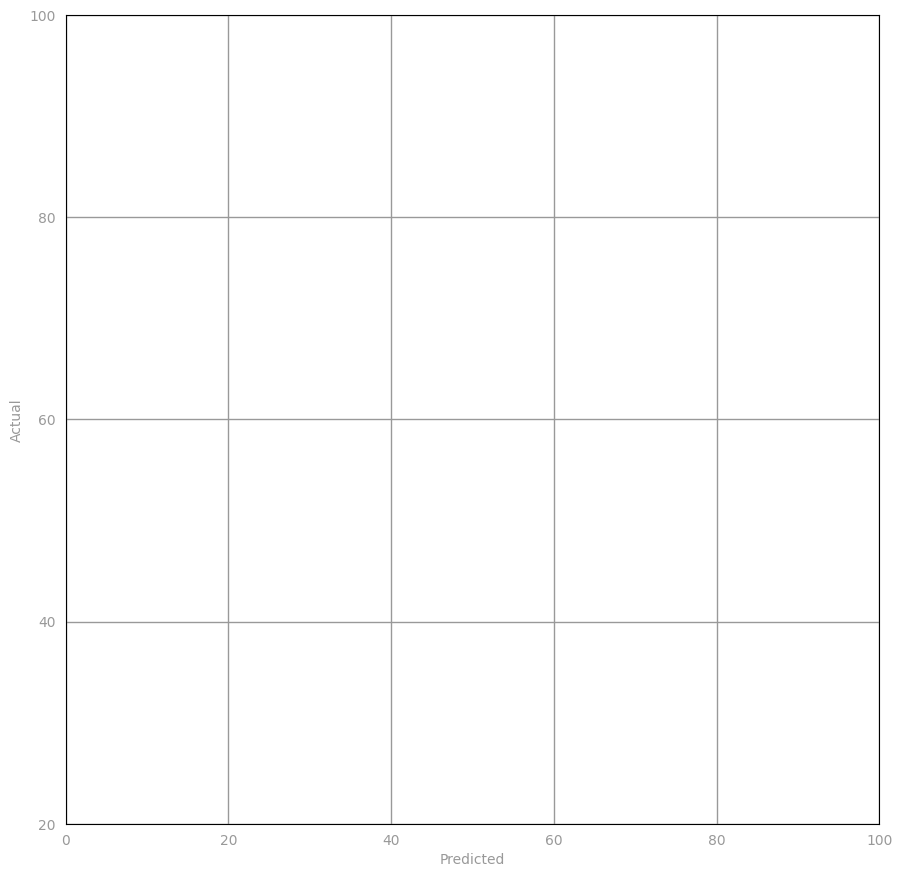

In [33]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap

cmap = get_cmap('YlOrRd')

def preparePlot(xticks, yticks, figsize=(10.5, 10.5), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

predictions = np.asarray(parsedCVDataOrderTwo
                         .map(lambda lp: secondModel.predict(lp.features))
                         .collect())

actual = np.asarray(parsedCVDataOrderTwo
                    .map(lambda lp: lp.label).collect())

error = np.asarray(parsedCVDataOrderTwo
                   .map(lambda lp: (lp.label, secondModel.predict(lp.features))).map(lambda lp: squaredError(lp[0], lp[1]))
                   .collect())

norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(0, 120, 20), np.arange(0, 120, 20))
ax.set_xlim(0, 100), ax.set_ylim(20, 100)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=.5)
ax.set_xlabel('Predicted'), ax.set_ylabel(r'Actual')
pass

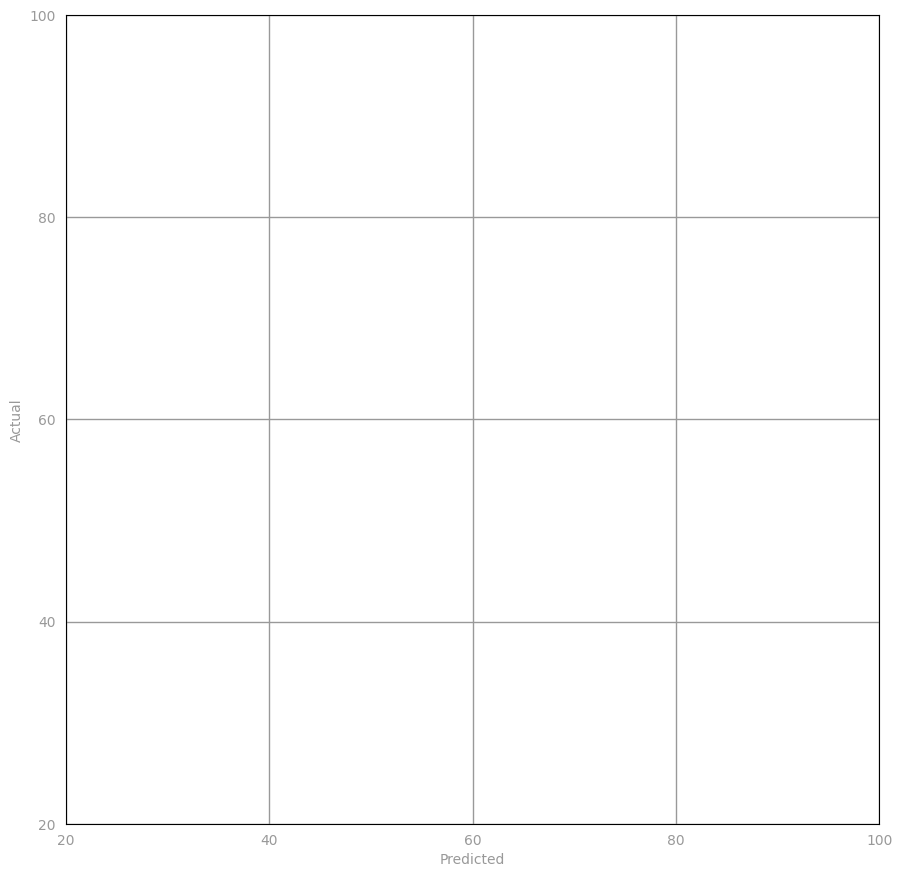

In [34]:
fig, ax = preparePlot(np.arange(0, 120, 20), np.arange(0, 120, 20))
ax.set_xlim(20, 100), ax.set_ylim(20, 100)
plt.scatter(predictions, predictions, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=.5)
ax.set_xlabel('Predicted'), ax.set_ylabel(r'Actual')
pass